## 自己构建的网络

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.layers import Lambda
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionV3_pre
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_pre
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.preprocessing import image   
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
from PIL import ImageFile  
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
import numpy as np
import pandas as pd
from glob import glob
import cv2                
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
%matplotlib inline 
import random
import os
import shutil
import h5py
import common
import pickle

Using TensorFlow backend.


In [6]:
def plot_info(file_name, acc_lengend, loss_lengend):
    with open(file_name, 'rb') as file:
        history = pickle.load(file)
        acc = history['acc']
        loss = history['loss']
        val_acc = history['val_acc']
        val_loss = history['val_loss']
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot(range(1, len(acc) + 1), acc, label='acc')
    plt.plot(range(1, len(acc) + 1), val_acc, label='val_acc')
    plt.xticks(range(1, len(acc) + 1));
    plt.legend(loc=acc_lengend, shadow=True, fontsize='x-large')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(122)
    plt.plot(range(1, len(loss) + 1), loss, label='loss')
    plt.plot(range(1, len(loss) + 1), val_loss, label='val_loss')
    plt.xticks(range(1, len(loss) + 1));
    plt.legend(loc=loss_lengend, shadow=True, fontsize='x-large')
    plt.xlabel('Epochs')
    plt.ylabel('LogLoss');



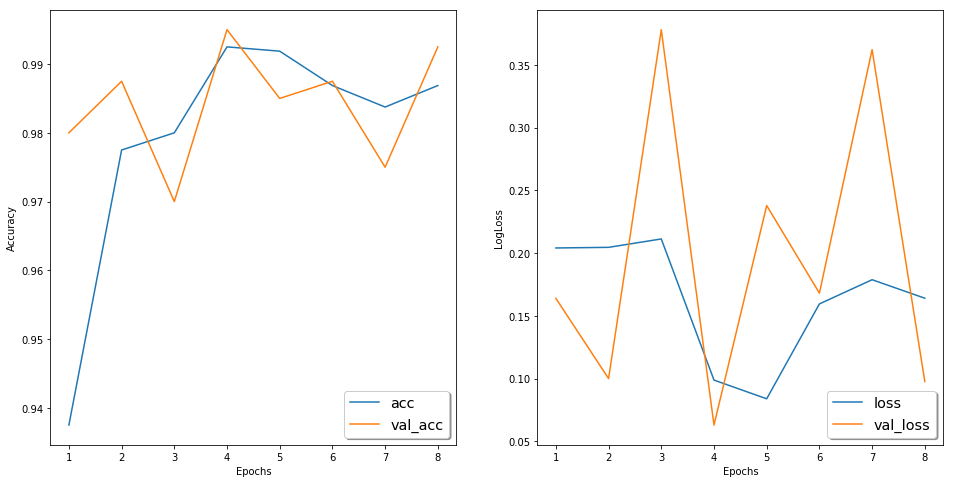

In [7]:
plot_info('small_inceptionV3_history.pkl', 'lower right', 'lower right')

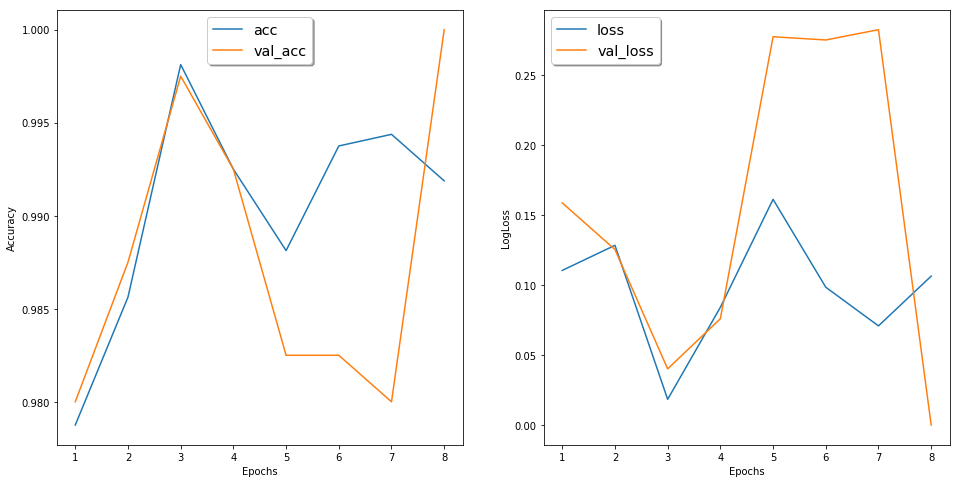

In [8]:
plot_info('small_xception_history.pkl', 'upper center', 'upper left')